In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 6.4 MB/s eta 0:00:00


In [2]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, io
from torch.utils.data.dataloader import default_collate
from torchmetrics.classification import BinaryRecall, BinaryPrecision
import pandas as pd
from skimage import io, transform
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding='same')
    self.bn1 = nn.BatchNorm2d(out_c)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding='same')
    self.bn2 = nn.BatchNorm2d(out_c)

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = F.leaky_relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = F.leaky_relu(x)
    return x

class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv_block = conv_block(in_c, out_c)

  def forward(self, inputs):
    x = self.conv_block(inputs)
    p = F.max_pool2d(x, 2)
    #print(f"Encoder x shape:{x.shape}, p shape: {p.shape}")
    return x, p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.up_conv = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0, output_padding=0)
    self.conv_block = conv_block(out_c+out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up_conv(inputs)
    d2 = skip.shape[2] - x.shape[2]
    d3 = skip.shape[3] - x.shape[3]
    #print(f"Decoder x shape:{x.shape}, skip shape: {skip.shape}")
    x = torch.cat([x, skip[:,:,d2//2:d2//2+x.shape[2],d3//2:d3//2+x.shape[3]]], axis=1)
    x = self.conv_block(x)
    return x

In [4]:
class build_unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.e1 = encoder_block(3, 64)
    self.e2 = encoder_block(64, 128)
    self.e3 = encoder_block(128, 256)
    self.e4 = encoder_block(256, 512)

    self.b = conv_block(512, 1024)

    self.d1 = decoder_block(1024, 512)
    self.d2 = decoder_block(512, 256)
    self.d3 = decoder_block(256, 128)
    self.d4 = decoder_block(128, 64)

    self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding='same')

  def forward(self, inputs):

    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)


    b = self.b(p4)
    #print(f"P4: {p4.shape}, b: {b.shape}")

    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    outputs = self.outputs(d4)
    outputs = F.sigmoid(outputs)
    return outputs

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
model = build_unet().to(device)
print(model)

build_unet(
  (e1): encoder_block(
    (conv_block): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (e2): encoder_block(
    (conv_block): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (e3): encoder_block(
    (conv_block): conv_block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn1): BatchNorm2d(256, eps=1e

In [7]:
def dice_coef(y_true, y_pred):
  smooth = 1e-15
  y_true = torch.flatten(y_true)
  y_pred = torch.flatten(y_pred)
  # print(f" y_true: {y_true.shape}")
  # print(f" y_pred: {y_pred.shape}")
  intersection = (y_true * y_pred).sum()
  return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)


In [10]:
def get_paths(img_dir, mask_dir):
  img_files = os.listdir(img_dir)
  mask_files = os.listdir(mask_dir)
  img_files.sort(key=lambda x: x.split('_')[0])
  mask_files.sort(key=lambda x: x.split('_')[0])
  for img, mask in zip(img_files, mask_files):
    if img.split('_')[0] != mask.split('_')[0]:
      raise Exception("Images and masks file names do not match")
  img_files = [os.path.join(img_dir, img) for img in img_files]
  mask_files = [os.path.join(mask_dir, mask) for mask in mask_files]
  X_train, X_test, y_train, y_test = train_test_split(img_files, mask_files, test_size=0.33, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)
  return X_train, y_train, X_test, y_test, X_val, y_val
paths_img_files_train, paths_mask_files_train, paths_img_files_test, paths_mask_files_test, paths_img_files_val, paths_mask_files_val = get_paths(img_dir="drive/MyDrive/data/images", mask_dir="drive/MyDrive/data/masks")

In [11]:
class CustomImageDataset(Dataset):
  def __init__(self, paths_img_files, paths_mask_files, transform=None, target_transform=None):
    self.paths_img_files = paths_img_files
    self.paths_mask_files = paths_mask_files
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.paths_img_files)

  def __getitem__(self, idx):
    img_path = self.paths_img_files[idx]
    mask_path = self.paths_mask_files[idx]
    image = Image.open(img_path)
    mask = io.imread(mask_path)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        mask = self.target_transform(mask)
    return image, mask

training_data = CustomImageDataset(
    paths_img_files=paths_img_files_train,
    paths_mask_files=paths_mask_files_train,
    transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]),
    target_transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]))
test_data = CustomImageDataset(
    paths_img_files=paths_img_files_test,
    paths_mask_files=paths_mask_files_test,
    transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]),
    target_transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]))
val_data = CustomImageDataset(
    paths_img_files=paths_img_files_val,
    paths_mask_files=paths_mask_files_val,
    transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]),
    target_transform=transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(592)]))

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
loss_fn = dice_loss
epochs = 100
history = {
    "train": {
      "loss": [],
      "recall": [],
      "precision": []
    },
    "val": {
      "loss": [],
      "recall": [],
      "precision": []
    }
}
for epoch in range(epochs):
  model.train() # tells your model that you are training the model
  for train_batch in train_dataloader:
    images, masks = train_batch
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_fn(outputs, masks)
    recall = BinaryRecall().to(device)(outputs, masks)
    precision = BinaryPrecision().to(device)(outputs, masks)
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch + 1}/{epochs}, Loss: {loss.item():.5f}, Recall: {recall.item():.2f} Precision: {precision.item():.2f}')
  history['train']['loss'].append(loss.item())
  history['train']['recall'].append(recall.item())
  history['train']['precision'].append(precision.item())

  model.eval()
  val_loss, val_recall, val_precision = [], [], []
  with torch.no_grad():
    for val_batch in val_dataloader:
      images, masks = val_batch
      outputs = model(images)
      val_loss.append(loss_fn(outputs, masks).item())
      val_recall.append(BinaryRecall().to(device)(outputs, masks).cpu())
      val_precision.append(BinaryPrecision().to(device)(outputs, masks).cpu())
  val_loss = np.mean(val_loss)
  val_recall = np.mean(val_recall)
  val_precision = np.mean(val_precision)
  print(f'Validation loss: {val_loss:.5f}, Validation recall: {val_recall:.2f} Validation precision: {val_precision:.2f}')
  history['val']['loss'].append(val_loss)
  history['val']['recall'].append(val_recall)
  history['val']['precision'].append(val_precision)

Epoch: 1/100, Loss: 0.78203, Recall: 0.97 Precision: 0.13
Validation loss: 0.85382, Validation recall: 0.00 Validation precision: 0.00
Epoch: 2/100, Loss: 0.76391, Recall: 0.90 Precision: 0.18
Validation loss: 0.85324, Validation recall: 0.00 Validation precision: 0.00
Epoch: 3/100, Loss: 0.69775, Recall: 0.70 Precision: 0.27
Validation loss: 0.85450, Validation recall: 0.00 Validation precision: 0.00
Epoch: 4/100, Loss: 0.56554, Recall: 0.85 Precision: 0.59
Validation loss: 0.85910, Validation recall: 0.00 Validation precision: 0.00
Epoch: 5/100, Loss: 0.62547, Recall: 0.88 Precision: 0.44
Validation loss: 0.87190, Validation recall: 0.00 Validation precision: 1.00
Epoch: 6/100, Loss: 0.63109, Recall: 0.77 Precision: 0.42
Validation loss: 0.88255, Validation recall: 0.00 Validation precision: 0.13
Epoch: 7/100, Loss: 0.60526, Recall: 0.90 Precision: 0.51
Validation loss: 0.87269, Validation recall: 0.03 Validation precision: 0.16
Epoch: 8/100, Loss: 0.58369, Recall: 0.88 Precision: 0.

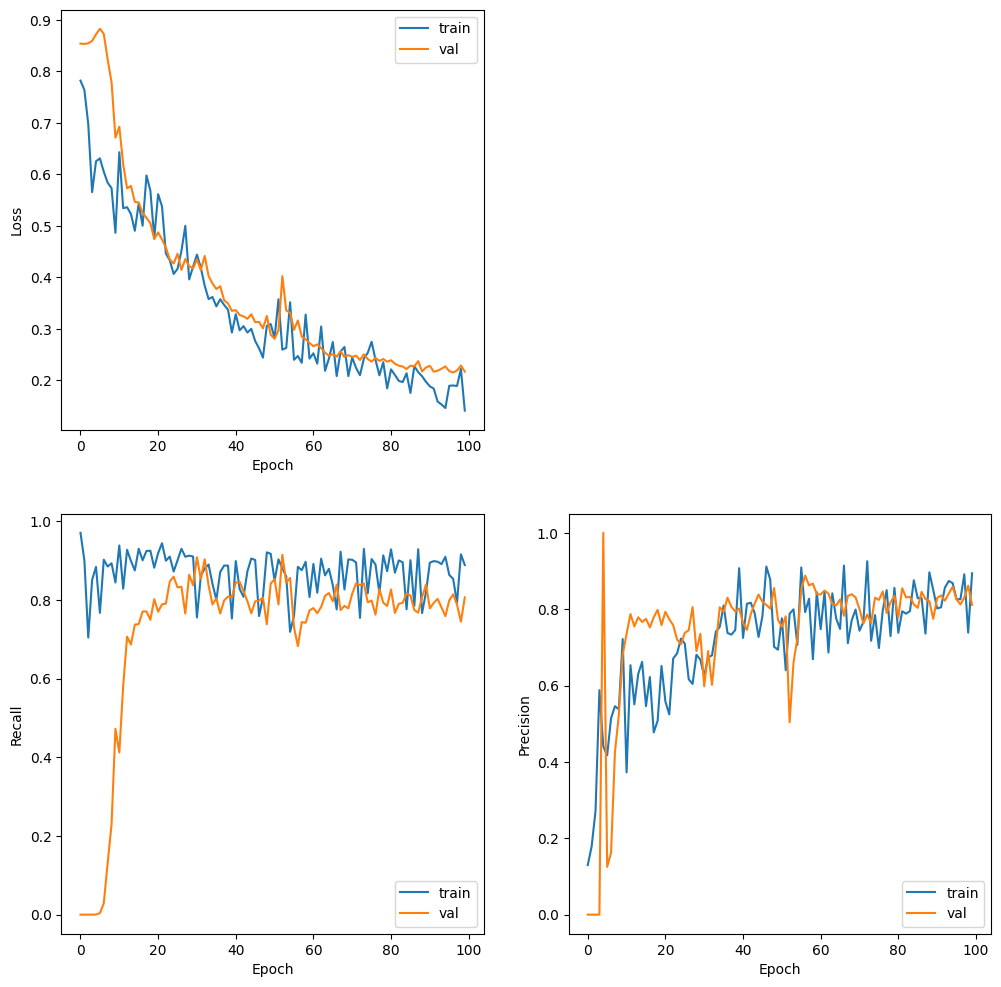

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history['train']['loss'])
plt.plot(history['val']['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')


plt.subplot(2, 2, 3)
plt.plot(history['train']['recall'])
plt.plot(history['val']['recall'])
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history['train']['precision'])
plt.plot(history['val']['precision'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'val'], loc='lower right')

plt.show()
plt.savefig('metrics.jpg')

In [14]:
model.eval()
test_loss, test_recall, test_precision = [], [], []
results=[]
with torch.no_grad():
  for test_batch in test_dataloader:
    images, masks = val_batch
    outputs = model(images)
    test_loss.append(loss_fn(outputs, masks).item())
    test_recall.append(BinaryRecall().to(device)(outputs, masks).cpu())
    test_precision.append(BinaryPrecision().to(device)(outputs, masks).cpu())

    predicted_masks = (outputs >= 0.5).float() * 1
    predicted_masks = predicted_masks
    for i, m, pm in zip(images, masks, predicted_masks):
      results.append([i, m, pm])
test_loss = np.mean(test_loss)
test_recall = np.mean(test_recall)
test_precision = np.mean(test_precision)
print(f'Test loss: {test_loss:.5f}, Test recall: {test_recall:.2f} Test precision: {test_precision:.2f}')

Test loss: 0.21724, Test recall: 0.81 Test precision: 0.81


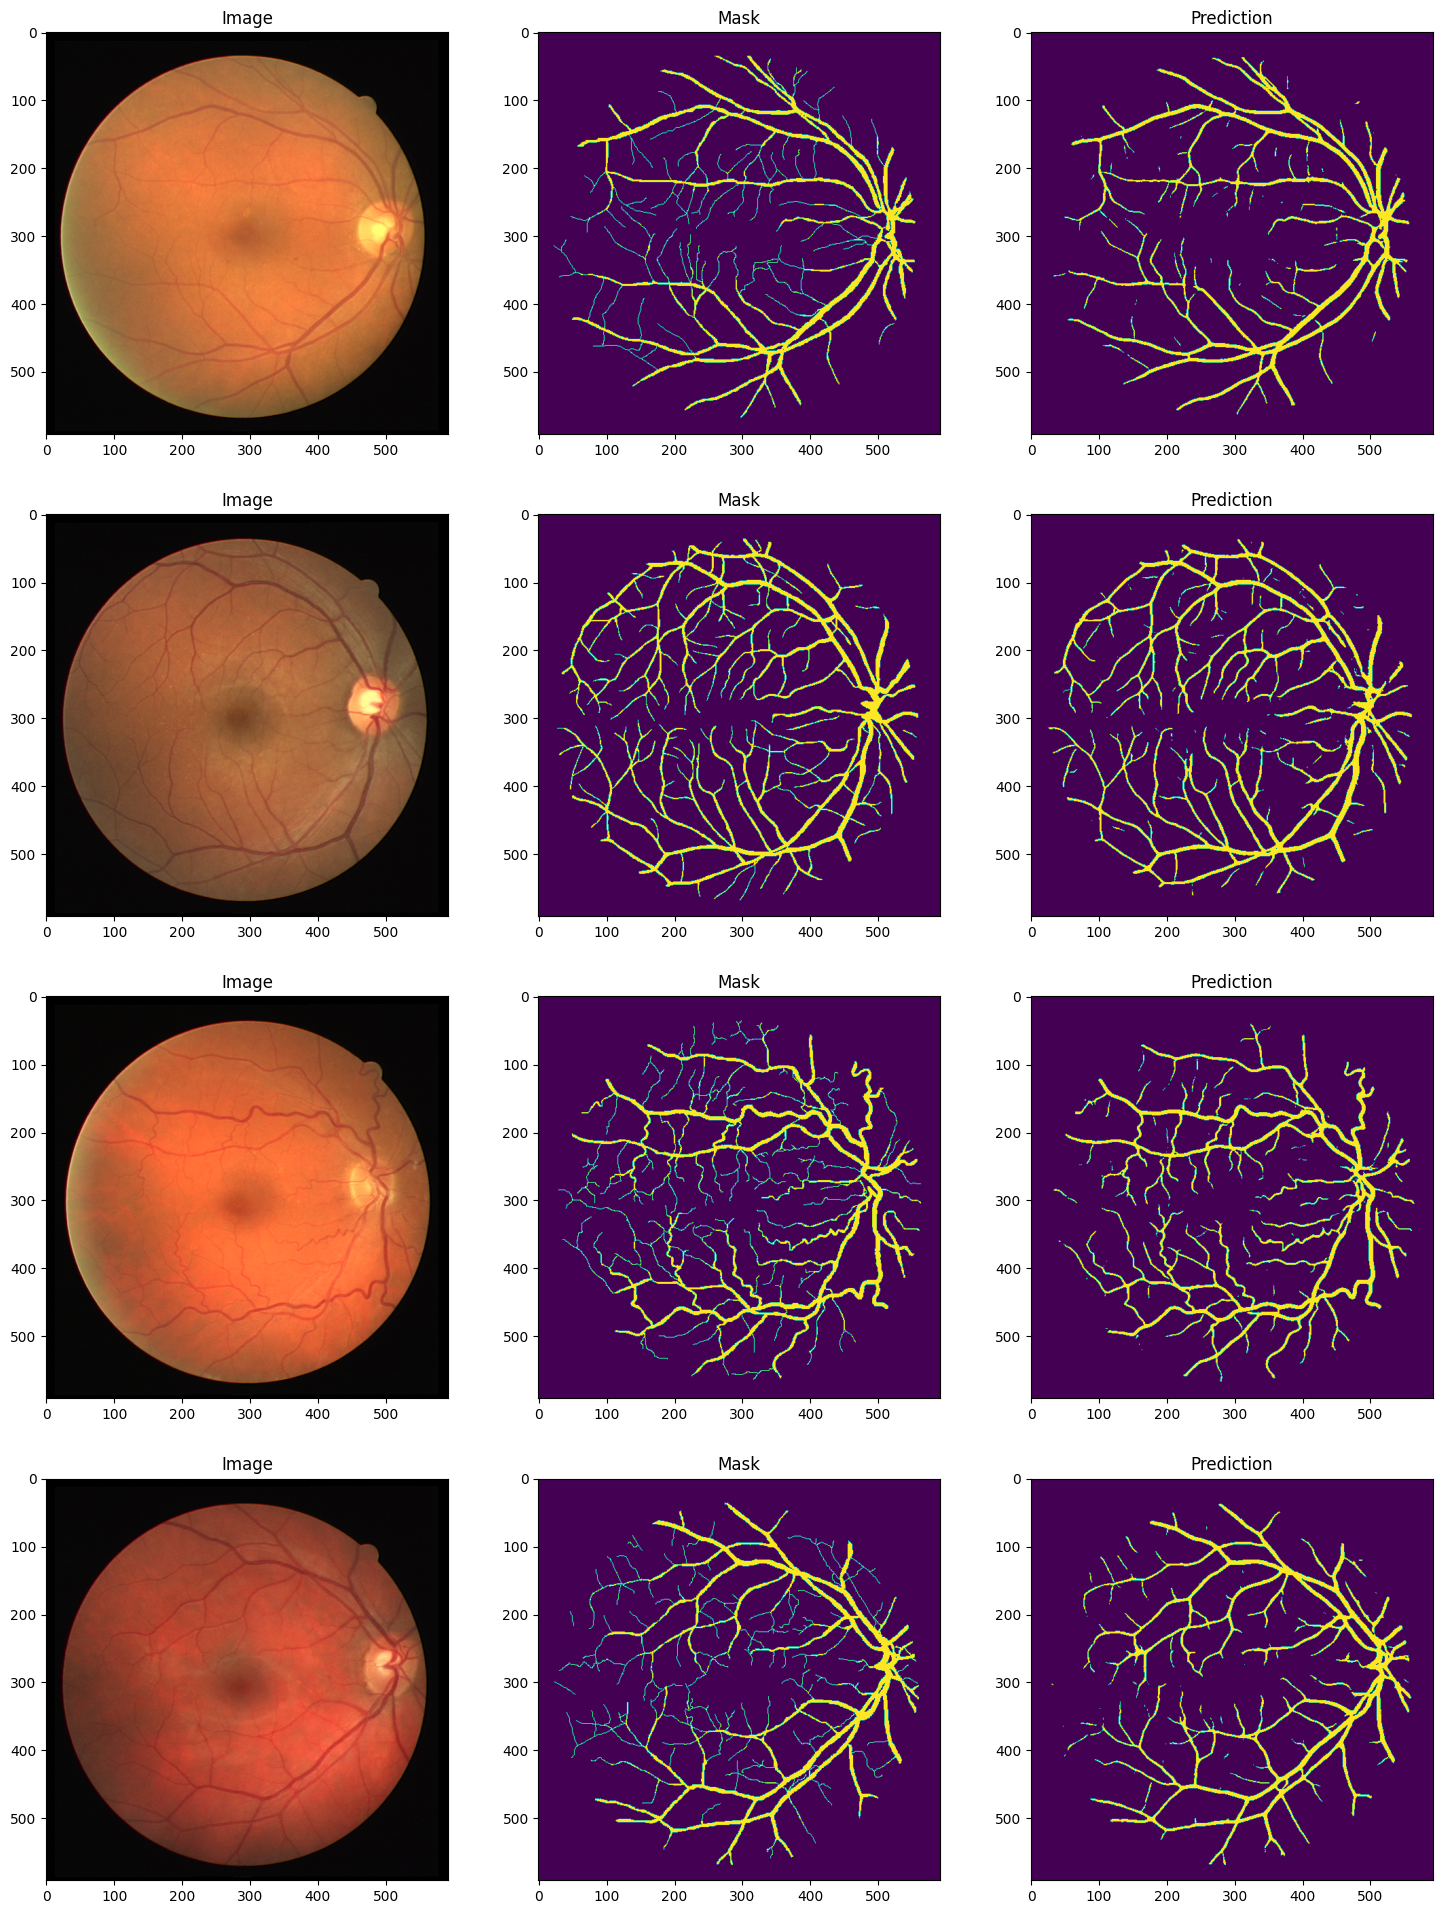

<Figure size 640x480 with 0 Axes>

In [15]:

plt.figure(figsize=(18, 24))
for i, [img, m, pm] in enumerate(results):
  plt.subplot(4, 3, i*3 + 1)
  plt.imshow(img.cpu().permute(1, 2, 0)  )
  plt.title('Image')

  plt.subplot(4, 3, i*3 + 2)
  plt.imshow(m.cpu().permute(1, 2, 0)  )
  plt.title('Mask')

  plt.subplot(4, 3, i*3 + 3)
  plt.imshow(pm.cpu().permute(1, 2, 0))
  plt.title('Prediction')

plt.show()
plt.savefig('results.jpg')